# Week 6: ODEs

In [2]:
import numpy as np
from numpy.linalg import eigvals
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# new packages for data fitting
import scipy.stats.qmc as lhs # for Latin Hypercube sampling (parameter scanning)
from scipy.interpolate import interp1d # for simulation interpolation in your scoring function
import scipy.optimize as opt # for constrained minimisation

# new package to help find steady states of limit cycle oscillators
from scipy.signal import find_peaks

# handy for checking paths in google colab:
#!ls -R

## 1 ODE

### 1.1 ODEs of the given reactions

$$
\frac{d[\mathrm{Glc}]}{dt} = - rφGlc
$$
$$
\frac{d[\mathrm{PEP}]}{dt} = rφ(Glc + OAA) + φPYR - PEP(1 + φ + d)
$$
$$
\frac{d[\mathrm{PYR}]}{dt} = rφOAA + φPEP - PYR(φ + d)
$$
$$
\frac{d[\mathrm{OAA}]}{dt} = PEP - φOAA
$$

𝜑 = max(1 - PYR, 𝜑(0))

fixed amount of glucose fed to the cells so Glc(0) = 1 mM

### 1.2 Code function for the given reactions

In [6]:
def original_model(state, t, r, d, phi0):
    Glc, PEP, PYR, OAA = state

    # added dynamic phi, as described in the assignment
    phi = max(1 - PYR, phi0)

    dGlc_dt = - r * phi * Glc

    dPEP_dt = r * phi * (Glc + OAA) + phi * PYR - PEP * (1 + phi + d)

    dPYR_dt = r * phi * OAA + phi * PEP - PYR * (phi + d)

    dOAA_dt = PEP - phi * OAA

    return [dGlc_dt, dPEP_dt, dPYR_dt, dOAA_dt]

## 2 Data

In [7]:
from google.colab import drive
drive.mount('/content/drive')

# I do not know if this works for you, but it connects the drive immediately with the data without needing to import them again

base_path = "/content/drive/My Drive/WUR/Modeling in Systems Biology/week_5/SSB Group Project/Code + Data/Data/"

file_r1 = base_path + "core_metabolism_r1.csv"
file_r01 = base_path + "core_metabolism_r01.csv"
file_r001 = base_path + "core_metabolism_r001.csv"

data_time, PEP_mean1, PEP_sd1, PYR_mean1, PYR_sd1 = np.loadtxt(file_r1, delimiter=",", unpack=True)
data_time, PEP_mean01, PEP_sd01, PYR_mean01, PYR_sd01 = np.loadtxt(file_r01, delimiter=",", unpack=True)
data_time, PEP_mean001, PEP_sd001, PYR_mean001, PYR_sd001 = np.loadtxt(file_r001, delimiter=",", unpack=True)

print("Loaded CSVs successfully!")


Mounted at /content/drive
Loaded CSVs successfully!


In [ ]:
# # Loading the data for all r values
# data_time, PEP_mean1, PEP_sd1, PYR_mean1, PYR_sd1 = np.loadtxt("./core_metabolism_data/core_metabolism_r1.csv",delimiter=",",unpack=True)
# data_time, PEP_mean01, PEP_sd01, PYR_mean01, PYR_sd01 = np.loadtxt("./core_metabolism_data/core_metabolism_r01.csv",delimiter=",",unpack=True)
# data_time, PEP_mean001, PEP_sd001, PYR_mean001, PYR_sd001 = np.loadtxt("./core_metabolism_data/core_metabolism_r001.csv",delimiter=",",unpack=True)

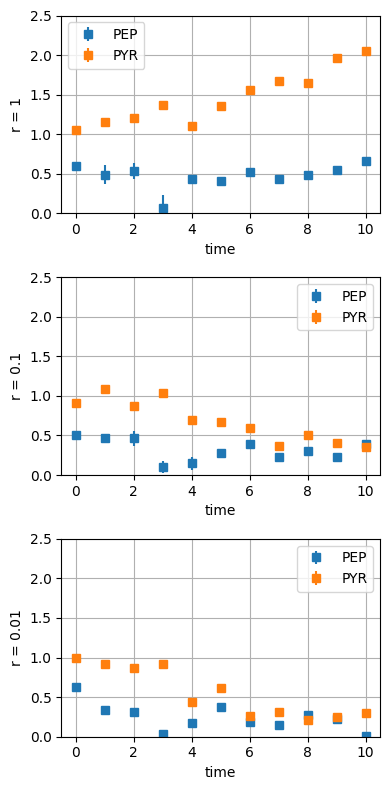

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(4, 8))

# --- r = 1 ---
axs[0].errorbar(data_time, PEP_mean1, PEP_sd1, marker='s', linestyle='', label='PEP')
axs[0].errorbar(data_time, PYR_mean1, PYR_sd1, marker='s', linestyle='', label='PYR')
axs[0].set_xlabel('time')
axs[0].set_ylabel('r = 1')
axs[0].set_ylim(0,2.5)
axs[0].grid(True)
axs[0].legend()

# --- r = 0.1 ---
axs[1].errorbar(data_time, PEP_mean01, PEP_sd01, marker='s', linestyle='', label='PEP')
axs[1].errorbar(data_time, PYR_mean01, PYR_sd01, marker='s', linestyle='', label='PYR')
axs[1].set_xlabel('time')
axs[1].set_ylabel('r = 0.1')
axs[1].set_ylim(0,2.5)
axs[1].grid(True)
axs[1].legend()

# --- r = 0.01 ---
axs[2].errorbar(data_time, PEP_mean001, PEP_sd001, marker='s', linestyle='', label='PEP')
axs[2].errorbar(data_time, PYR_mean001, PYR_sd001, marker='s', linestyle='', label='PYR')
axs[2].set_xlabel('time')
axs[2].set_ylabel('r = 0.01')
axs[2].set_ylim(0,2.5)
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.show()


In [ ]:
IC_r1 = [PEP_mean1[0], PYR_mean1[0]]
IC_r01 = [PEP_mean01[0], PYR_mean01[0]]
IC_r001 = [PEP_mean001[0], PYR_mean001[0]]

In [ ]:
r1 = 1
r01 = 0.1
r001 = 0.01
d = 10**-6
phi0 = 0.1
pars1 = (r1, d, phi0) #r,d,phi0
pars01 = (r01, d, phi0) #r,d,phi0
pars001 = (r001, d, phi0) #r,d,phi0

t_values = np.linspace(0, 10, 101)

GLCinit = 1
PEPinit = PEP_mean1[0]
PYRinit = PYR_mean1[0]
OAAinit = 1
OAAinit_range = np.linspace(0.5,2, 11)
IC = [GLCinit, PEPinit, PYRinit, OAAinit]

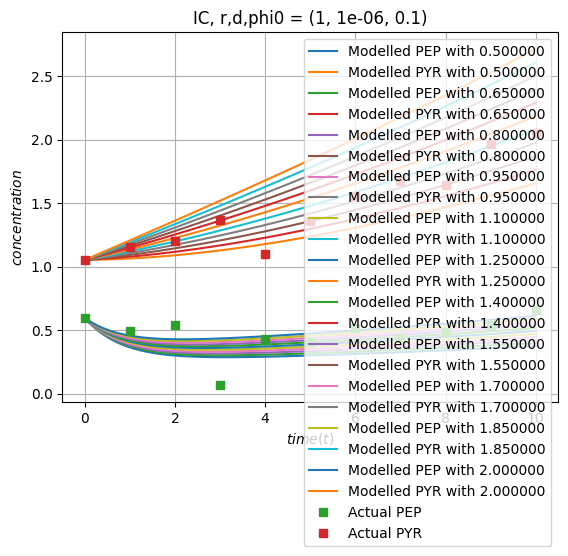

In [ ]:
for OAA in OAAinit_range:
  IC = [GLCinit, PEPinit, PYRinit, OAA]
  data1 = odeint(ode_function, IC, t_values, args = pars1)
  plt.plot(t_values, data1[:, 1], label=f"Modelled PEP with {OAA:2f}")
  plt.plot(t_values, data1[:, 2], label=f"Modelled PYR with {OAA:2f}")

plt.plot(data_time, PEP_mean1, marker='s', linestyle='', label='Actual PEP')
plt.plot(data_time, PYR_mean1, marker='s', linestyle='', label='Actual PYR')
plt.title(f"IC, r,d,phi0 = {pars1}")
plt.xlabel('$time (t)$')
plt.ylabel('$concentration$')
plt.legend()
plt.grid(True)
plt.show()

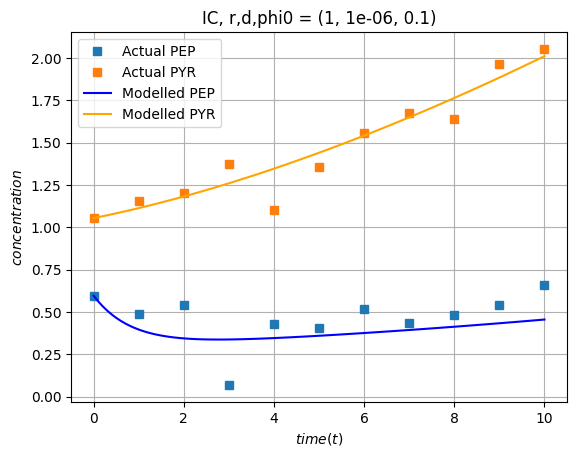

In [ ]:
data1 = odeint(ode_function, IC, t_values, args = pars1)

plt.plot(data_time, PEP_mean1, marker='s', linestyle='', label='Actual PEP')
plt.plot(data_time, PYR_mean1, marker='s', linestyle='', label='Actual PYR')

plt.plot(t_values, data1[:, 1], label="Modelled PEP", color = "blue")
plt.plot(t_values, data1[:, 2], label="Modelled PYR", color = "orange")
plt.title(f"IC, r,d,phi0 = {pars1}")
plt.xlabel('$time (t)$')
plt.ylabel('$concentration$')
plt.legend()
plt.grid(True)
plt.show()

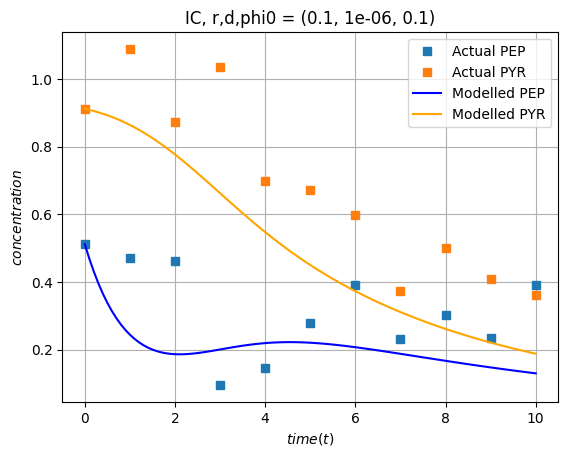

In [ ]:
r01 = 0.1
pars01 = (r01, d, phi0) #r,d,phi0

PEPinit = PEP_mean01[0]
PYRinit = PYR_mean01[0]
IC = [GLCinit, PEPinit, PYRinit, OAAinit]

data01 = odeint(ode_function, IC, t_values, args = pars01)

plt.plot(data_time, PEP_mean01, marker='s', linestyle='', label='Actual PEP')
plt.plot(data_time, PYR_mean01, marker='s', linestyle='', label='Actual PYR')

plt.plot(t_values, data01[:, 1], label="Modelled PEP", color = "blue")
plt.plot(t_values, data01[:, 2], label="Modelled PYR", color = "orange")
plt.title(f"IC, r,d,phi0 = {pars01}")
plt.xlabel('$time (t)$')
plt.ylabel('$concentration$')
plt.legend()
plt.grid(True)
plt.show()

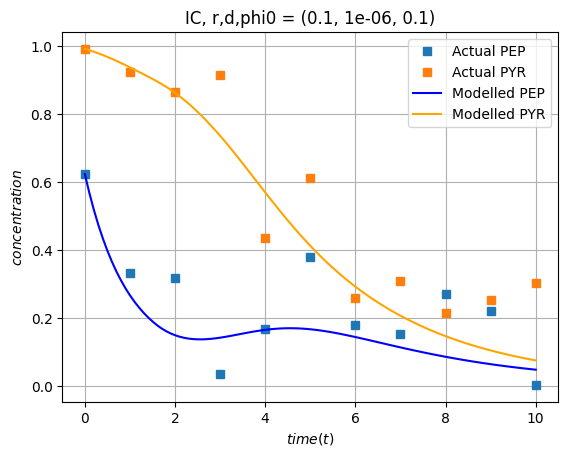

In [ ]:
r001 = 0.01
pars001 = (r001, d, phi0) #r,d,phi0

PEPinit = PEP_mean001[0]
PYRinit = PYR_mean001[0]
IC001 = [GLCinit, PEPinit, PYRinit, OAAinit]

data001 = odeint(ode_function, IC001, t_values, args = pars001)

plt.plot(data_time, PEP_mean001, marker='s', linestyle='', label='Actual PEP')
plt.plot(data_time, PYR_mean001, marker='s', linestyle='', label='Actual PYR')

plt.plot(t_values, data001[:, 1], label="Modelled PEP", color = "blue")
plt.plot(t_values, data001[:, 2], label="Modelled PYR", color = "orange")
plt.title(f"IC, r,d,phi0 = {pars01}")
plt.xlabel('$time (t)$')
plt.ylabel('$concentration$')
plt.legend()
plt.grid(True)
plt.show()

Bounds are needed for parameters that we cannot control or we do not know, i.e. $N(0), d, phi(0)$. The bounds will be set on a logarithmic scale (i.e. -1 implies 10$^{-1}$ = 0.1). This is common practice, particularly in models where there are some very slow and some very fast rates. We will use the following bounds (for adding, use \\ after the latter line)

\begin{align}
\log_{10}(d) &\in (-9,-6) \nonumber
\end{align}

In [5]:
def simplified_model(state, t, r, d, phi0):
    PEP, PYR = state

    # added dynamic phi, as described in the assignment
    phi = np.maximum(1 - PYR, phi0)

    dGlc_dt = 0

    dPEP_dt = r * PEP + phi * PYR - PEP * (1 + phi + d)

    dPYR_dt = r * PEP + phi * PEP - PYR * (phi + d)

    return [dPEP_dt, dPYR_dt]

In [ ]:
def score_function(ps): #ps = paramater set

    # Unpack parameters
    OAAinit = 10**ps[0]  #bounds = [0.001 - 10]
    d = 10**ps[1]    #bounds =
    phi0 = 10**ps[2] #bounds =

    # set timespan and initial conditions of the system
    times = np.linspace(0,10,1001)
    initial_conditions = [0, PEP_mean1[0], PYR_mean1[0], OAAinit] # [Glc(0), PEP(0), PYR(0), OAA(0)]

    # simulate r=0.01
    r = 0.01
    pars = (r, d, phi0)
    xt1 = odeint(original_model, initial_conditions, times, pars)

    # for each concentration we now want to interpolate the simulation
    # we do this so that we only have simulated concentrations at
    # the same timepoints as where the data is measured
    # (an advantage to this approach is that calculating our score
    # then becomes a vector equation!)

    interp_GLC001 = interp1d(times,xt1[:,0])
    sim_Nlow = interp_GLC001(data_time)

    interp_PEP001 = interp1d(times,xt1[:,1])
    sim_Clow = interp_Clow(data_time)

    interp_PYR001 = interp1d(times,xt1[:,2])
    sim_Blow = interp_PYR001(data_time)

    interp_OAA001 = interp1d(times,xt1[:,3])
    sim_Blow = interp_OAA001(data_time)

    # simulate r=0.1
    r = 0.1
    pars = (r, d, phi0)
    xt2 = odeint(original_model, initial_conditions, times, pars)

    # interpolate simulations
    interp_GLC01 = interp1d(times, xt1[:,0])
    sim_Nlow = interp_GLC01(data_time)

    interp_PEP01 = interp1d(times, xt1[:,1])
    sim_Clow = interp_PEP01(data_time)

    interp_PYR01 = interp1d(times, xt1[:,2])
    sim_Blow = interp_PYR01(data_time)

    interp_OAA01 = interp1d(times, xt1[:,3])
    sim_OAA = interp_OAA01(data_time)

    # simulte r=1
    r = 1
    pars = (r, d, phi0)
    xt3 = odeint(original_model, initial_conditions, times, pars)

    # interpolate simulations
    interp_GLC1 = interp1d(times, xt1[:,0])
    sim_Nlow = interp_GLC1(data_time)

    interp_PEP1 = interp1d(times, xt1[:,1])
    sim_Clow = interp_PEP1(data_time)

    interp_PYR1 = interp1d(times, xt1[:,2])
    sim_Blow = interp_PYR1(data_time)

    interp_OAA1 = interp1d(times, xt1[:,3])
    sim_OAA = interp_OAA1(data_time)

    # Calculate score (mean_lowN = PEP_mean001)
    omega_001 = np.sum((mean_001GLC[1:]-sim_GLC001[1:])**2/var_001GLC[1:]) + np.sum((mean_001PEP[1:]-sim_PEP001[1:])**2/var_001PEP[1:]) + np.sum((mean_001PYR[1:]-sim_PYR001[1:])**2/var_001PYR[1:]) + np.sum((mean_001OAA[1:]-sim_OAA001[1:])**2/var_001OAA[1:])
    omega_01  = np.sum((mean_01GLC[1:]-sim_GLC01[1:])**2/var_01GLC[1:]) + np.sum((mean_01PEP[1:]-sim_PEP01[1:])**2/var_01PEP[1:]) + np.sum((mean_01PYR[1:]-sim_PYR01[1:])**2/var_01PYR[1:]) + np.sum((mean_01OAA[1:]-sim_OAA01[1:])**2/var_01OAA[1:])
    omega_1   = np.sum((mean_1GLC[1:]-sim_GLC1[1:])**2/var_1GLC[1:]) + np.sum((mean_1PEP[1:]-sim_PEP1[1:])**2/var_1PEP[1:]) + np.sum((mean_1PYR[1:]-sim_PYR1[1:])**2/var_1PYR[1:]) + np.sum((mean_1OAA[1:]-sim_OAA1[1:])**2/var_1OAA[1:])

    # Sum up subscores to one value
    score = omega_001 + omega_01 + omega_1

    return score

Creating random parameter values for OAA, d, and phi(0), and doing that a 1000 times:

In [3]:
# Order parameters: OAA, d, phi(0) # No N(0)
#lower_bounds = [-3,0.2,]
#upper_bounds = [-1,0.4,]
lower_bounds = [-3, -9, -3]
upper_bounds = [1, -6, 0]
# So phi(0) in this is between 0.001 and 1, in the description it says between 0 and 1.
# So OAAinit in this is between 0.001 and 10, in the description it says between 0 and 10.
r1 = 1
r01 = 0.1
r001 = 0.01

# Create Latin Hypercube sample for d=2 dimensions
# Latin Hypercube samples create random sets of numbers between 0 and 1, so we need to stretch these bound using the for-loop below.
sampler = lhs.LatinHypercube(d=3)
sample = sampler.random(n=1000)

# Now, for each row/parameter in the sample matrix, we need to re-scale these using the bounds
for i in range(0, 3):
    sample[:,i] = lower_bounds[i] + (upper_bounds[i]-lower_bounds[i])*sample[:,i]
print(sample)
type(sample)
sample.dtype
sample.shape
# So the Latin Hypercube is creating random values within the bounds we have gotten in the project description.
# There are thus random values between these bounds for all 3 parameters for 1000 times.

[[-0.77396371 -8.93619092 -1.055636  ]
 [-1.30892411 -6.056456   -0.89147007]
 [-1.13136888 -7.11904341 -2.58807716]
 ...
 [ 0.62069367 -6.51780094 -2.87952309]
 [-2.2208169  -7.58578421 -1.6258296 ]
 [-1.12420659 -6.35356107 -0.70591363]]


(1000, 3)

In [ ]:
eigenvalues = np.zeros((4, 4, len(sample[:,0])), dtype = np.complex128) # Changed the np.complex_ to np.complex128
print(eigenvalues.shape)
eigenvalue_parameters = np.zeros((len(sample[:,0]), 1))

(4, 4, 1000)
